In [1]:
import sys
sys.path.append('../elfi')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from functools import partial
import ipyparallel

%matplotlib inline
from IPython.display import Image

In [2]:
import logging
logging.basicConfig(level=logging.CRITICAL)

In [3]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

# ELFI - Engine for Likelihood-Free Inference


Work Presentation 25 April 2017

Henri Vuollekoski and the ELFI team
(Jarno Lintusaari, Antti Kangasrääsiö, Kusti Skyten et al.)

## Brief intro to ABC (Approximate Bayesian Computation)

Bayesian inference is powerful, but what if you <font color=red> don't know the likelihood </font> function?

If you have a simulator to generate data, you can (possibly) use ABC!

![ok](abc_Lintusaari.png)

## Example: the 2nd order Moving Average model (MA2)

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2}
$$

In [4]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    t1 = np.atleast_2d(t1).reshape((-1, 1))
    t2 = np.atleast_2d(t2).reshape((-1, 1))    
    if random_state is None:
        random_state = np.random.RandomState()
    w = random_state.randn(batch_size, n_obs+  2)
    y = w[:, 2:] + t1 * w[:, 1:-1] + t2 * w[:, :-2]
    return y 

### Generate some "observed" data:

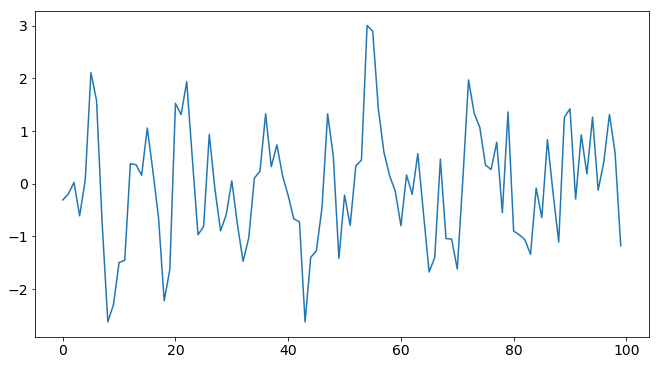

In [5]:
# true parameters
t1_true = 0.6
t2_true = 0.2

# Set up observed data y with some random seed
random_state = np.random.RandomState(20161130)
y_obs = MA2(t1_true, t2_true, random_state=random_state)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.flatten());

### To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:

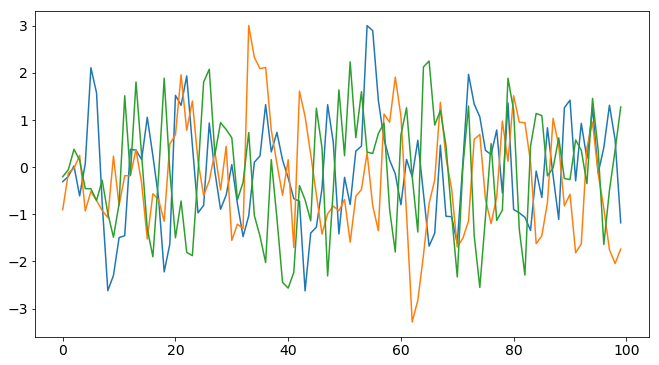

In [6]:
plt.figure(figsize=(11, 6));
plt.plot(y_obs.flatten());
plt.plot(MA2(t1_true, t2_true).flatten());
plt.plot(MA2(t1_true, t2_true).flatten());

### How can you compare these?

### Comparing noisy data

Calculate the discrepancy (distance) between some summary statistics, like the first two autocovariances:

In [7]:
def autocov(x, lag=1):
    mu = np.mean(x, axis=1, keepdims=True)
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True) - mu**2.
    return C

def distance(*simulated, observed):
    d = np.linalg.norm(np.array(simulated) - np.array(observed),
                       ord=2, axis=0)
    return d

And then what?

In [8]:
import elfi

## Using ELFI to infer the parameters

In [9]:
t1 = elfi.Prior(scipy.stats.uniform, 0, 2)
t2 = elfi.Prior('uniform', 0, 2)

In [10]:
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

In [11]:
S1 = elfi.Summary(autocov, Y)

autocov2 = partial(autocov, lag=2)
S2 = elfi.Summary(autocov2, Y)

In [12]:
d = elfi.Discrepancy(distance, S1, S2)

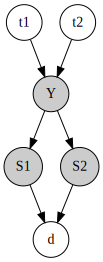

In [13]:
elfi.draw(d)

### We could proceed... but being equal is not always nice

In [14]:
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size,
                                    random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)
        return p

class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, 
                                     random_state=random_state)
        return t2
    
    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)
        return p

### These priors sample from a triangle

$-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$

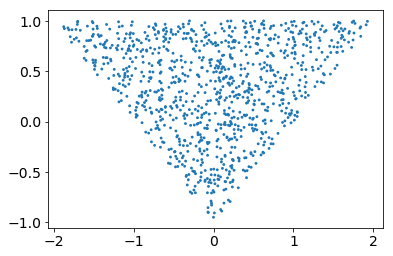

In [15]:
t1_1000 = CustomPrior_t1.rvs(2, 1000)
t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=8, edgecolor='none');

### Redefine the model with these priors

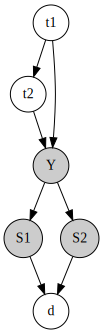

In [16]:
elfi.reset_current_model()

t1 = elfi.Prior(CustomPrior_t1, 2)
t2 = elfi.Prior(CustomPrior_t2, t1, 1)
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov2, Y)
d = elfi.Discrepancy(distance, S1, S2)

elfi.draw(d)

### Now we just sample *a lot* to get an approximate posterior

In [17]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

result = rej.sample(1000, quantile=0.01)

In [18]:
result.summary()

Method: Rejection
Number of posterior samples: 1000
Number of simulations: 100000
Threshold: 0.114
Posterior means: t1: 0.613, t2: 0.189


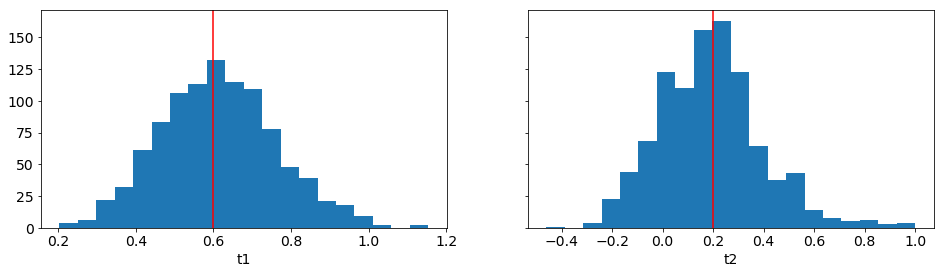

In [19]:
ax = result.plot_marginals();
ax[0].axvline(t1_true, color='r');
ax[1].axvline(t2_true, color='r');

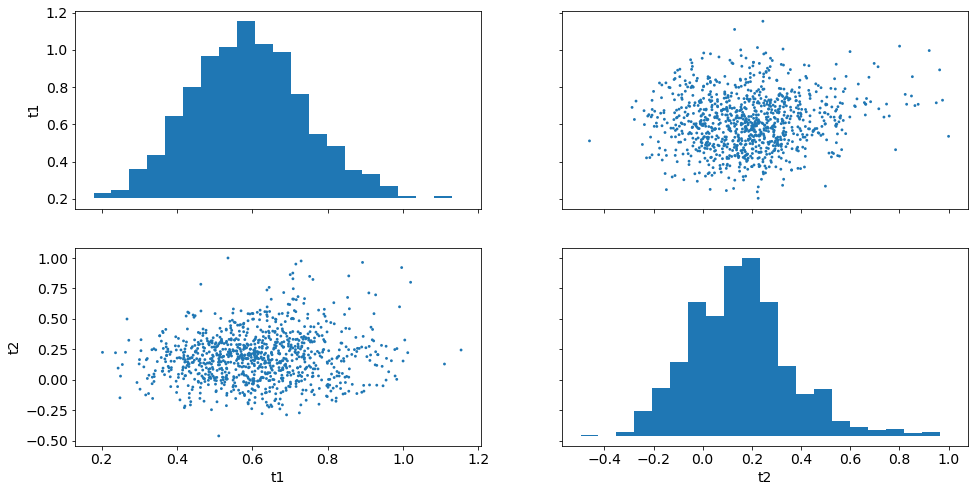

In [20]:
result.plot_pairs(s=8);

## Let's do that in parallel!

Currently ELFI supports the powerful *ipyparallel* library for parallel and distributed computing.

In [21]:
!PYTHONPATH=${PYTHONPATH}:../elfi && ipcluster start -n 4 --daemon
    
import elfi.clients.ipyparallel

In [22]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

result2 = rej.sample(100000, quantile=0.01)

In [23]:
!ipcluster stop

## Sequential Monte Carlo ABC (Importance sampling)

In [24]:
smc = elfi.SMC(d, [t1, t2], batch_size=10000)

schedule = [0.7, 0.2, 0.05]

result_smc = smc.sample(1000, schedule)

In [25]:
result_smc.summary()

Method: SMC-ABC
Number of posterior samples: 1000
Number of simulations: 120000
Threshold: 0.0491
Posterior means: t1: 0.599, t2: 0.171


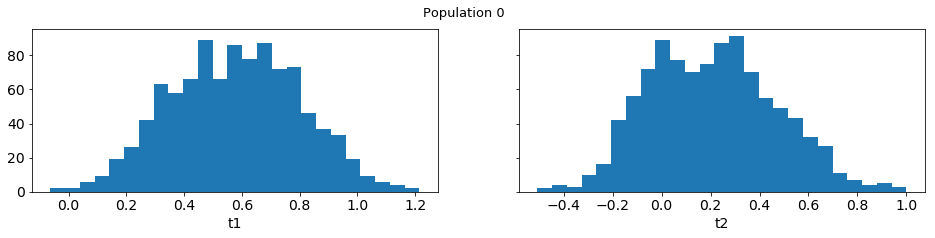

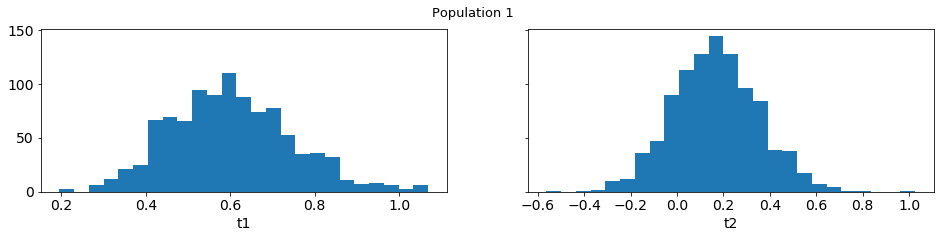

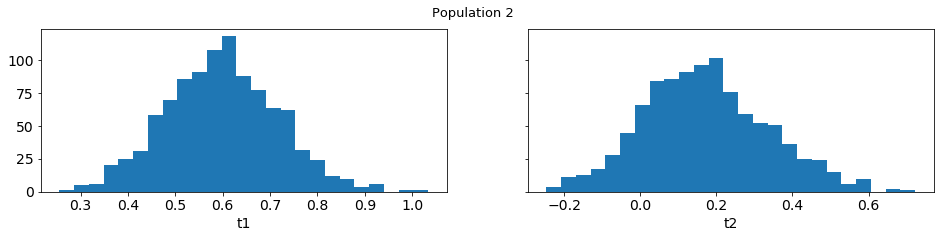

In [26]:
result_smc.plot_marginals_all_populations(bins=25, figsize=(16, 3))

## BOLFI (Bayesian Optimization for Likelihood-Free Inference)

In [27]:
log_distance = lambda *simulated, observed: \
               np.log(distance(*simulated, observed=observed))

log_d = elfi.Discrepancy(log_distance, S1, S2)

In [28]:
bolfi = elfi.BOLFI(log_d, [t1, t2], n_acq=50, batch_size=5,
                   initial_evidence=20, update_interval=10, 
                   bounds=[(0, 2), (0, 2)])
bolfi.infer()

{'samples': {'t1': 0.4652, 't2': 0.1177}}

### ELFI currently uses GPy for Gaussian processes

In [29]:
print(bolfi.target_model._gp)


Name : GP regression
Objective : 56.001192065723714
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  sum.rbf.variance         |  0.485492361259  |      +ve      |        
  sum.rbf.lengthscale      |  0.765222492598  |      +ve      |        
  sum.bias.variance        |  0.154519224516  |      +ve      |        
  Gaussian_noise.variance  |  0.195187892675  |      +ve      |        


 /Users/vuolleh2/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


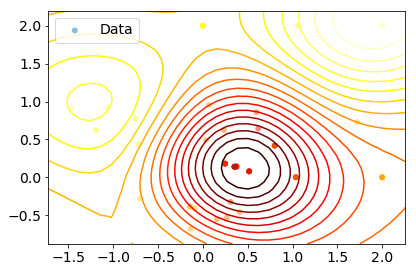

In [30]:
bolfi.target_model._gp.plot();

In [31]:
post = bolfi.get_posterior()

In [32]:
chains = bolfi.sample(1000)

4 chains of 1000 samples acquired. Effective sample size and Rhat for each parameter:
t1 60.2128321116 1.01428489139
t2 48.4520010824 1.00394097755


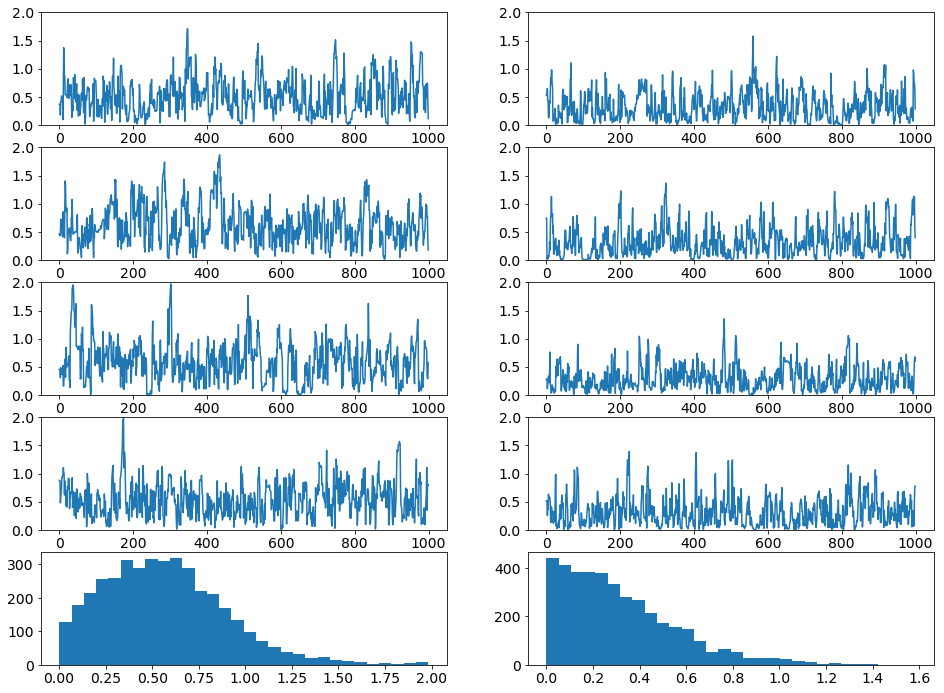

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(16, 12))
for ii in range(4):
    for jj in range(2):
        ax[ii, jj].plot(chains[ii, :, jj]);
        ax[ii, jj].set_ylim(0, 2)
ax[4, 0].hist(chains[:, :, 0].ravel(), bins=30);
ax[4, 1].hist(chains[:, :, 1].ravel(), bins=30);

In [34]:
!ipcluster stop

2017-04-25 11:31:18.374 [IPClusterStop] Stopping cluster [pid=39478] with [signal=<Signals.SIGINT: 2>]
